<a href="https://colab.research.google.com/github/caguilarglz/IA-Generativa/blob/main/Proyecto_IA_Informacion_Deloitte_Legal_RAG_web.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<h1 align="center"><strong>Ejemplo utilizando Mistral-7b y LangChain</strong></h1>

---

### **Introducción**

RAG de Mistral 7B para cliente Deloitte Legal (se usa como ejemplo)


### **Empezamos**

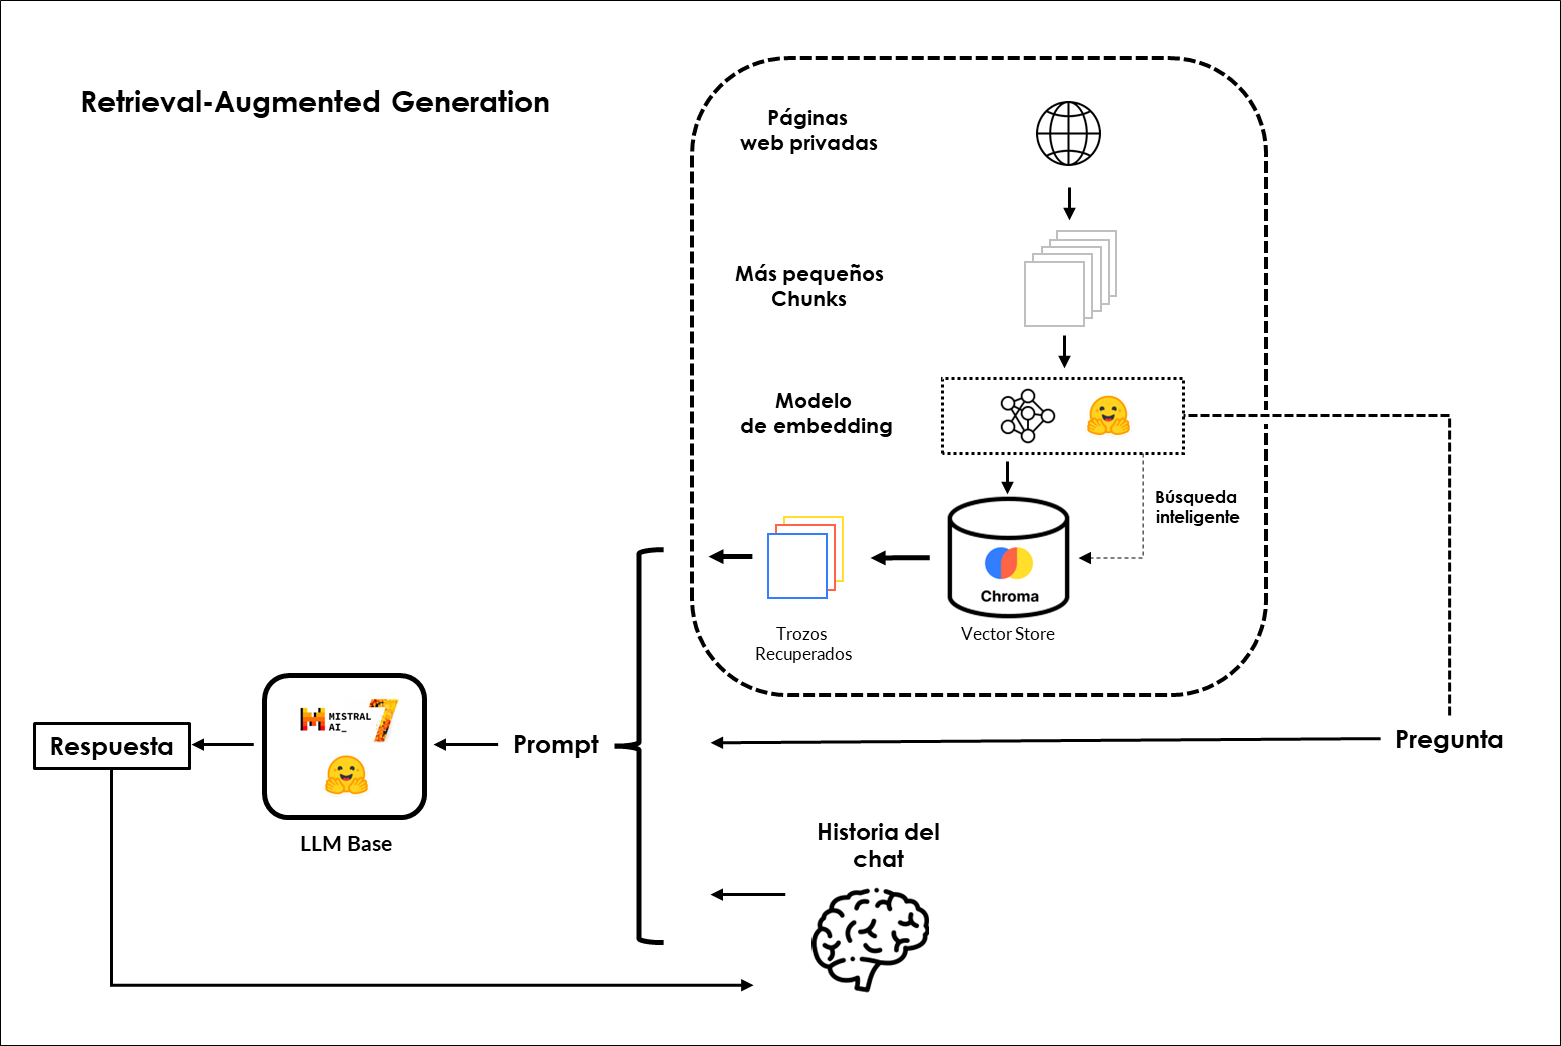

#### Instalaciones

In [ ]:
!pip install gradio --quiet
!pip install xformer --quiet
!pip install chromadb --quiet
!pip install langchain --quiet
!pip install accelerate --quiet
!pip install transformers --quiet
!pip install bitsandbytes --quiet
!pip install unstructured --quiet
!pip install sentence-transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 96.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 11.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into accou

#### Importaciones

In [ ]:
import torch
import gradio as gr

from textwrap import fill
from IPython.display import Markdown, display

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    )

from langchain import PromptTemplate
from langchain import HuggingFacePipeline

from langchain.vectorstores import Chroma
from langchain.schema import AIMessage, HumanMessage
from langchain.memory import ConversationBufferMemory
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import UnstructuredMarkdownLoader, UnstructuredURLLoader
from langchain.chains import LLMChain, SimpleSequentialChain, RetrievalQA, ConversationalRetrievalChain

from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline

import warnings
warnings.filterwarnings('ignore')

#### LLM Base

**Mistral-7b** desarrollado por **Mistral AI** está arrasando en el panorama de los LLM de código abierto. Este nuevo LLM de código abierto supera a LLaMA-2 en muchas pruebas comparativas, como ilustra la siguiente imagen extraída de su documento:

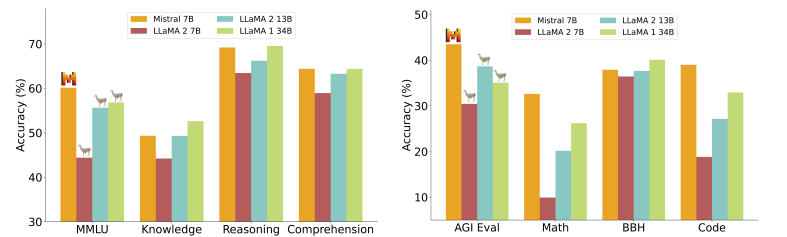

El siguiente fragmento de código se configura un **proceso de generación de texto** utilizando un LLM base, **Mistral-7b** desarrollado por **Mistral AI**, instruye al modelo de lenguaje preentrenado, lo configura con ajustes de **cuantización**, **tokenización** y **parámetros de generación**, y crea un proceso que puede utilizarse para generar texto basado en el LLM **Mistral-7b** y las configuraciones. Vamos a desglosar lo que sucede:

* **`quantization_config = BitsAndBytesConfig(...)`**: Aquí se define una configuración de **cuantización** utilizando **BitsAndBytesConfig**. La cuantificación es una técnica utilizada para reducir los requisitos de memoria y computación de los modelos de aprendizaje profundo, normalmente mediante el uso de **menos bits**, **4 bits** en nuestro caso para representar los parámetros del modelo.

* **`tokenizer = AutoTokenizer.from_pretrained(...)`**: Esta línea inicializa un tokenizador para el modelo **Mistral-7b**, permitiéndole preprocesar datos de texto para introducirlos en el modelo.

* **`model = AutoModelForCausalLM.from_pretrained(...)`**: Esto inicializa el modelo de lenguaje **Mistral-7b** pre-entrenado para el modelado causal del lenguaje. El modelo se configura con varios parámetros, incluyendo la **configuración** de **cuantización**, que se estableció anteriormente.

* **`generation_config = GenerationConfig.from_pretrained(...)`**: Se crea una **configuración de generación** para el modelo, especificando varios parámetros relacionados con la generación, como el **número máximo de tokens**, la **temperature** para el **sampling**, el **top-p sampling** y la **repetition penalty**.

* **`pipeline = pipeline(...)`**: Por último, se crea una línea de generación de texto utilizando la función **pipeline**. Esta tubería se configura para la generación de texto, y toma el modelo pre-entrenado, el tokenizer, y la configuración de generación como entradas. Está configurado para devolver salidas de texto completo.


In [ ]:
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.1"

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=quantization_config
)

generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
generation_config.max_new_tokens = 1024
generation_config.temperature = 0.0001
generation_config.top_p = 0.95
generation_config.do_sample = True
generation_config.repetition_penalty = 1.15

pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=True,
    generation_config=generation_config,
)

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

**HuggingFacePipeline** es una clase que permite ejecutar modelos Hugging Face localmente. Se utiliza para acceder y utilizar una amplia gama de modelos ML pre-entrenados alojados en el Hugging Face Model Hub. En nuestro caso, la utilizaremos dentro de nuestro entorno LangChain para interactuar con los modelos de Hugging Face como **local wrapper**. Sin embargo, cuando se trabaja con HuggingFacePipeline, se recomienda la instalación de **xformer** para una implementación de atención más eficiente en memoria. Por eso lo hemos instalado más arriba.

In [ ]:
llm = HuggingFacePipeline(
    pipeline=pipeline,
    )

In [ ]:
query = "Explain the difference between ChatGPT and open source LLMs in a couple of lines."
result = llm(
    query
)

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>Explain the difference between ChatGPT and open source LLMs in a couple of lines.</b>

<p>
ChatGPT is a proprietary model developed by OpenAI, while open source LLMs are models that are made available for anyone to use, modify, and distribute under an open-source license.</p>

#### Embeddings

Después de establecer nuestro LLM base, es hora de establecer un **modelo de embedding**. Como sabes, cada documento debe convertirse en un **vector de embedding** para permitir la búsqueda semántica utilizando la consulta del usuario, que también debe incrustarse. Para ello, utilizaremos el modelo de incrustación **GTE** entrenado por **Alibaba DAMO Academy** y alojado en Hugging Face. Cabe destacar que este modelo es **gratuito** y **potente**. Para llevar a cabo nuestra tarea, utilizaremos la clase **HuggingFaceEmbeddings**, un pipeline wrapper local para interactuar con el modelo GTE alojado en Hugging Face Hub.

In [ ]:
embeddings = HuggingFaceEmbeddings(
    model_name="thenlper/gte-large",
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},
)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

#### Prompt Template

In [ ]:
template = """
[INST] <>
Act as a Machine Learning engineer who is teaching high school students.
<>

{text} [/INST]
"""

prompt = PromptTemplate(
    input_variables=["text"],
    template=template,
)

In [ ]:
query = "Explain what are Deep Neural Networks in 2-3 sentences"
result = llm(prompt.format(text=query))

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

#### Carga de datos

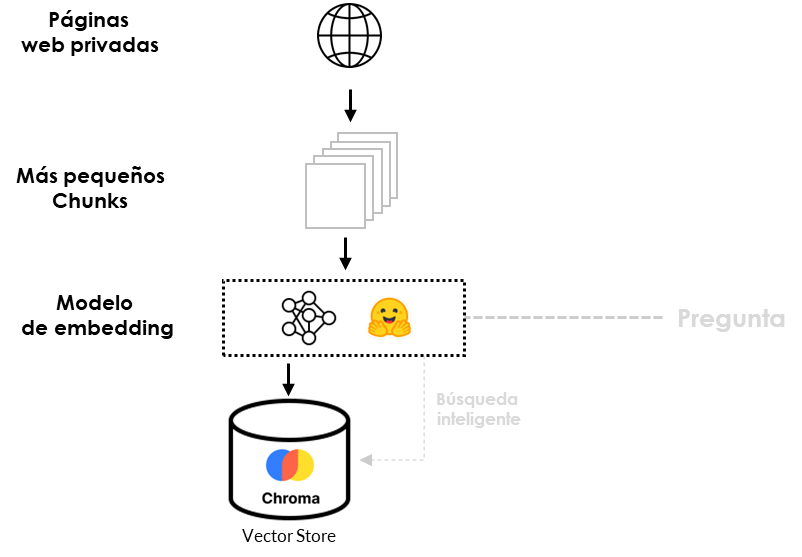

In [ ]:
urls = [
    "https://www2.deloitte.com/es/es.html",
    "https://www2.deloitte.com/es/es/pages/legal/solutions/derecho-laboral.html"
    "https://www2.deloitte.com/es/es/pages/legal/articles/reforma-laboral.html"
]

loader = UnstructuredURLLoader(urls=urls)
documents = loader.load()

len(documents)
# output: 2

2

Ahora tenemos dos documentos de gran tamaño repletos de datos, y eso podría superar la **ventana de contexto** de nuestro Mistral-7b LLM. Para mantener todo bajo control, vamos a dividirlos en **21 documentos más pequeños** o **chunks**, cada uno con un límite de **1024 tokens**. Además, hemos fijado el tamaño de **chunk overlap** en **64** para garantizar que haya cierta continuidad de contexto entre trozos consecutivos. Permanece atento al próximo paso en la ingesta de esta aventura de datos.

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts_chunks = text_splitter.split_documents(documents)

len(texts_chunks)
# output: 21

36

#### Ingesta de datos

Una vez que tenemos nuestros trozos de datos manejables, el siguiente paso es incrustarlos e indexarlos en **Chromdb**, nuestro **vector store**. ¿Y lo mejor? Es muy fácil y se puede hacer con una sola línea de código.

In [ ]:
db = Chroma.from_documents(texts_chunks, embeddings, persist_directory="db")

Una vez indexados nuestros datos, en el script que aparece a continuación, ajustamos nuestra plantilla de consulta para que se adapte a nuestras necesidades y damos a nuestro modelo de RAG la personalidad de un experto en gestión de marketing.

Además, para combinar nuestro LLM con las capacidades de recuperación de la base de datos vectorial, utilizamos el componente crucial de encadenamiento **RetrievalQA** con **`k=2`**. Esta configuración garantiza que el recuperador produzca dos fragmentos relevantes, que el LLM utiliza para formular la respuesta cuando se presenta una pregunta.

In [ ]:
template = """
[INST] <>
Act as an Deloitte Legal manager expert. Use the following information to answer the question at the end.
<>

{context}

{question} [/INST]
"""

prompt = PromptTemplate(template=template, input_variables=["context", "question"])

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

#### Querying

In [ ]:
query = "What is Deloitte Legal?"
result_ = qa_chain(
    query
)
result = result_["result"].strip()


display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>What is Deloitte Legal?</b>

<p>Deloitte Legal is a professional services firm that provides legal advice and solutions to businesses, organizations, and individuals. The company offers a range of legal services, including corporate law, taxation, intellectual property, dispute resolution, and regulatory compliance. Deloitte Legal operates in over 100 countries worldwide and is part of the global Deloitte network of professional services firms.</p>

In [ ]:
result_["source_documents"]

[Document(page_content='Forensic\n                                             \n                                          \n                                       \n                                    \n                                 \n                              \n                           \n                        \n                           \n                              Deloitte Legal\n                              \n                           \n                        \n                           \n                              Business Process Solutions', metadata={'source': 'https://www2.deloitte.com/es/es/pages/legal/solutions/derecho-laboral.htmlhttps://www2.deloitte.com/es/es/pages/legal/articles/reforma-laboral.html'}),
 Document(page_content='Forensic\n                                             \n                                          \n                                       \n                                    \n                                 \n            

#### Follow-Up Q/A

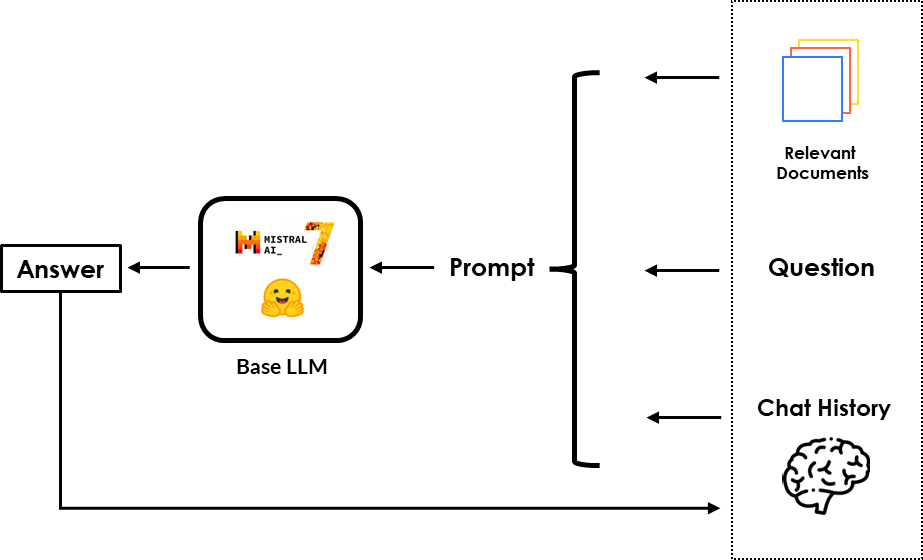

In [ ]:
custom_template = """You are an Deloitte Manager AI Assistant. Given the
following conversation and a follow up question, rephrase the follow up question
to be a standalone question. At the end of standalone question add this
'Answer the question in English language.' If you do not know the answer reply with 'I am sorry, I dont have enough information'.
Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:
"""

CUSTOM_QUESTION_PROMPT = PromptTemplate.from_template(custom_template)

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

qa_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    memory=memory,
    condense_question_prompt=CUSTOM_QUESTION_PROMPT,
)

In [ ]:
query = "Who you are?"
result_ = qa_chain({"question": query})
result = result_["answer"].strip()

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>Who you are?</b>

<p>I am a job search tool for people looking for jobs in Spain.</p>

In [ ]:
query = "What is GenIA Ecosystem?"

result_ = qa_chain({"question": query})
result = result_["answer"].strip()

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

In [ ]:
query = "Why it has been created?"

result_ = qa_chain({"question": query})
result = result_["answer"].strip()

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

In [ ]:
memory.chat_memory.messages

### **Gradio Chat UI**

In [ ]:
def querying(query, history):
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

  qa_chain = ConversationalRetrievalChain.from_llm(
      llm=llm,
      retriever=db.as_retriever(search_kwargs={"k": 2}),
      memory=memory,
      condense_question_prompt=CUSTOM_QUESTION_PROMPT,
  )

  result = qa_chain({"question": query})
  return result["answer"].strip()

In [ ]:
iface = gr.ChatInterface(
    fn = querying,
    chatbot=gr.Chatbot(height=600),
    textbox=gr.Textbox(placeholder="What is Deloitte?", container=False, scale=7),
    title="DeloitteChat",
    theme="soft",
    examples=["What services Deloitte offers?",
              "What is Deloitte Espana?"],

    cache_examples=True,
    retry_btn="Repetir",
    undo_btn="Deshacer",
    clear_btn="Borrar",
    submit_btn="Enviar"

    )

iface.launch(share=True)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Caching examples at: '/content/gradio_cached_examples/63'
Caching example 1/2


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Caching example 2/2
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://b7425609a6c7e7bff8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


___